# Gradient Descent Optimizations

Mini-batch and stochastic gradient descent is widely used in deep learning, where the large number of parameters and  limited memory make the use of more sophisticated optimization methods impractical. Many methods have been proposed to accelerate gradient descent in this context, and here we sketch the ideas behind some of the most popular algorithms.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Smoothing with exponentially weighted averages

In [3]:
n = 50
x = np.arange(n) * np.pi
y = np.cos(x) * np.exp(x/100) - 10*np.exp(-0.01*x)

### Exponentially weighted average

The exponentially weighted average adds a fraction $\beta$ of the current value to a leaky running sum of past values. Effectively, the contribution from the $t-n$th value is scaled by

$$
\beta^n(1 - \beta)
$$

For example, here are the contributions to the current value after 5 iterations (iteration 5 is the current iteration)

| iteration | contribution |
| --- | --- |
| 1 | $\beta^4(1 - \beta)$ |
| 2 | $\beta^3(1 - \beta)$ |
| 3 | $\beta^2(1 - \beta)$ |
| 4 | $\beta^1(1 - \beta)$ |
| 5 | $(1 - \beta)$ |

Since $\beta \lt 1$, the contribution decreases exponentially with the passage of time. Effectively, this acts as a smoother for a function.

In [4]:
def ewa(y, beta):
    """Exponentially weighted average."""
    
    zs = np.zeros(len(y))
    z = 0
    for i in range(n):
        z = beta*z + (1 - beta)*y[i]
        zs[i] = z
    return zs

### Exponentially weighted average with bias correction

Since the EWA starts from 0, there is an initial bias. This can be corrected by scaling with 

$$
\frac{1}{1 - \beta^t}
$$

where $t$ is the iteration number.

In [5]:
def ewabc(y, beta):
    """Exponentially weighted average with hias correction."""
    
    zs = np.zeros(len(y))
    z = 0
    for i in range(n):
        z = beta*z + (1 - beta)*y[i]
        zc = z/(1 - beta**(i+1))
        zs[i] = zc
    return zs

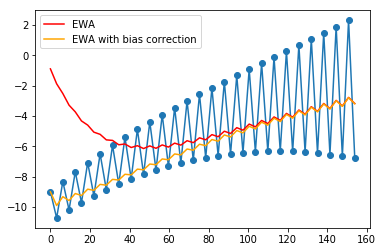

In [6]:
beta = 0.9

plt.plot(x, y, 'o-')
plt.plot(x, ewa(y, beta), c='red', label='EWA')
plt.plot(x, ewabc(y, beta), c='orange', label='EWA with bias correction')
plt.legend()
pass

## Momentum in 1D

Momentum comes from physics, where the contribution of the gradient is to the velocity, not the position. Hence we create an accessory variable $v$ and increment it with the gradient. The position is then updated with the velocity in place of the gradient. The analogy is that we can think of the parameter $x$ as a particle in an energy well with potential energy $U = mgh$ where $h$ is given by our objective function $f$. The force generated is a function of the rat of change of potential energy $F \propto \nabla U \propto \nabla f$, and we use $F = ma$ to get that the acceleration $a \propto \nabla f$. Finally, we integrate $a$ over time to get the velocity $v$ and integrate $v$ to get the displacement $x$. Note that we need to damp the velocity otherwise the particle would just oscillate forever.

We use a version of the update that simply treats the velocity as an exponentially weighted average popularized by Andrew Ng in his Coursera course. This is the same as the momentum scheme motivated by physics with some rescaling of constants.

In [7]:
def f(x):
    return x**2

In [8]:
def grad(x):
    return 2*x

In [9]:
def gd(x, grad, alpha, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1] = x
    return xs

In [10]:
def gd_momentum(x, grad, alpha, beta=0.9, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)
        vc = v/(1+beta**(i+1))
        x = x - alpha * vc
        xs[i+1] = x
    return xs

### Gradient descent with moderate step size

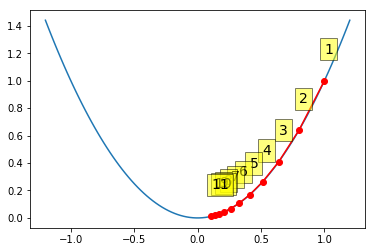

In [11]:
alpha = 0.1
x0 = 1
xs = gd(x0, grad, alpha)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i, 
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
pass

### Gradient descent with large step size

When the step size is too large, gradient descent can oscillate and even diverge.

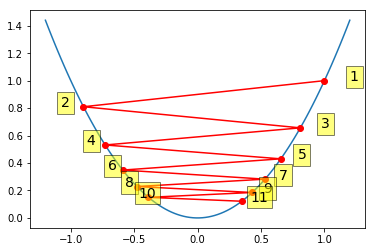

In [12]:
alpha = 0.95
xs = gd(1, grad, alpha)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x*1.2, y, i,
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
pass

### Gradient descent with momentum

Momentum results in cancellation of gradient changes in opposite directions, and hence damps out oscillations while amplifying consistent changes in the same direction. This is perhaps clearer in the 2D example below.

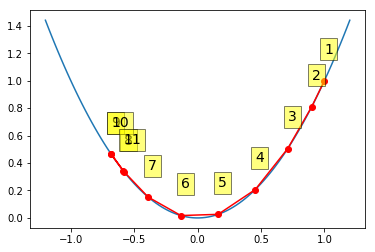

In [13]:
alpha = 0.95
xs = gd_momentum(1, grad, alpha, beta=0.9)
xp = np.linspace(-1.2, 1.2, 100)
plt.plot(xp, f(xp))
plt.plot(xs, f(xs), 'o-', c='red')
for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
    plt.text(x, y+0.2, i, 
             bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
pass

## Momentum and RMSprop in 2D

In [14]:
def f2(x):
    return x[0]**2 + 100*x[1]**2

In [15]:
def grad2(x):
    return np.array([2*x[0], 200*x[1]])

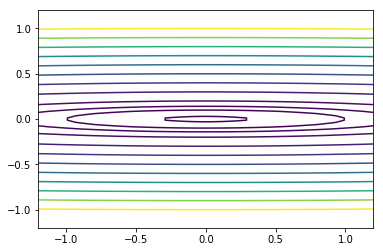

In [16]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
pass

In [17]:
def gd2(x, grad, alpha, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0,:] = x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1,:] = x
    return xs

In [18]:
def gd2_momentum(x, grad, alpha, beta=0.9, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0, :] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)
        vc = v/(1+beta**(i+1))
        x = x - alpha * vc
        xs[i+1, :] = x
    return xs

### Gradient descent with large step size

We get severe oscillations.

In [19]:
alpha = 0.01
x0 = np.array([-1,-1])
xs = gd2(x0, grad2, alpha, max_iter=75)

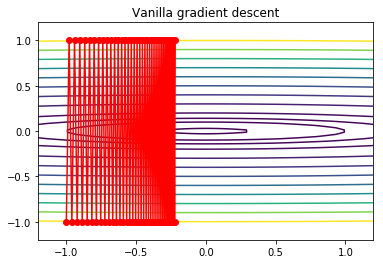

In [20]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Vanilla gradient descent')
pass

### Gradient descent with momentum

The damping effect is clear.

In [21]:
alpha = 0.01
x0 = np.array([-1,-1])
xs = gd2_momentum(x0, grad2, alpha, beta=0.9, max_iter=75)

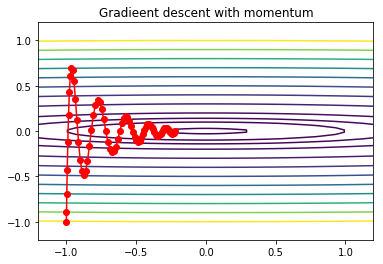

In [22]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Gradieent descent with momentum')
pass

### Gradient descent with RMSprop

RMSprop scales the learning rate in each direction by the square root of the exponentially weighted sum of squared gradients. Near a saddle or any plateau, there are directions where the gradient is very small - RMSporp encourages larger steps in those directions, allowing faster escape.

In [23]:
def gd2_rmsprop(x, grad, alpha, beta=0.9, eps=1e-8, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0, :] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x)**2
        x = x - alpha * grad(x) / (eps + np.sqrt(v))
        xs[i+1, :] = x
    return xs

In [24]:
alpha = 0.1
x0 = np.array([-1,-1])
xs = gd2_rmsprop(x0, grad2, alpha, beta=0.9, max_iter=10)

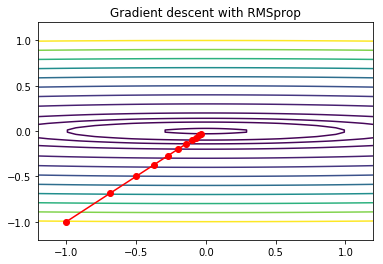

In [25]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Gradient descent with RMSprop')
pass

### ADAM

ADAM (Adaptive Moment Estimation) combines the ideas of momentum, RMSprop and bias correction. It is probably the most popular gradient descent method in current deep learning practice.

In [26]:
def gd2_adam(x, grad, alpha, beta1=0.9, beta2=0.999, eps=1e-8, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0, :] = x
    m = 0
    v = 0
    for i in range(max_iter):
        m = beta1*m + (1-beta1)*grad(x)
        v = beta2*v + (1-beta2)*grad(x)**2
        mc = m/(1+beta1**(i+1))
        vc = v/(1+beta2**(i+1))
        x = x - alpha * m / (eps + np.sqrt(vc))
        xs[i+1, :] = x
    return xs

In [27]:
alpha = 0.1
x0 = np.array([-1,-1])
xs = gd2_adam(x0, grad2, alpha, beta1=0.9, beta2=0.9, max_iter=10)

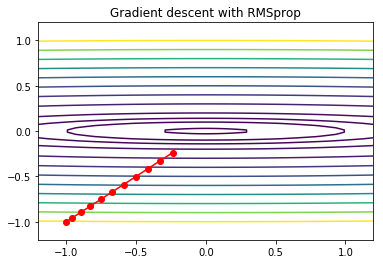

In [28]:
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
levels = [0.1,1,2,4,9, 16, 25, 36, 49, 64, 81, 100]
Z = x**2 + 100*Y**2
c = plt.contour(X, Y, Z, levels)
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Gradient descent with RMSprop')
pass